In [47]:
%load_ext autoreload
%autoreload 2
import sys
#sys.path.append('/Users/arimorcos/Github/getRedditDataset/')
sys.path.append('D:\Documents\GitHub\getRedditDataset')
#from celebReddit import countWords
import redditDB
import datetime
import praw
from matplotlib import pyplot as pp
from matplotlib import colorbar as cb
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as PD
import scipy
from scipy import spatial
from sklearn import cluster, decomposition
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
""" Establish database connection """
db = redditDB.RedditDB('March2-8_Top200')

In [9]:
""" Get comments from subreddits """
subList = praw.Reddit(user_agent='pop').get_popular_subreddits(limit=200)
subList = [sub.display_name for sub in subList]
comments = db.getSubredditCommentText(subList[0])

In [10]:
""" Strip formatting """ 
comments = [''.join(s for s in comment if ord(s)>31 and ord(s)<126) for comment in comments]

In [11]:
""" Enumerate words to get list and values """
def countNWords(allWords):
    wordCounts = {}
    for word in allWords:
        if word in wordCounts:
            wordCounts[word] += 1 
        else: 
            wordCounts[word] = 1
    return wordCounts

In [12]:
""" Concatenate all comments together and split into individual words """ 
allComments = " ".join(comments)
allWords = allComments.split()
allWords = [word.lower() for word in allWords]
wordCounts = countNWords(allWords)

In [13]:
""" sort by values and get 100 most frequent words""" 
sortedWords = sorted(wordCounts, key=wordCounts.get, reverse=True)
mostFreqWords = sortedWords[0:100]

In [14]:
freqWordCounts = [wordCounts[word] for word in mostFreqWords]

In [15]:
usedSubs = subList[0:50]
allCounts = np.zeros(shape=(len(mostFreqWords) ,len(usedSubs)))
subInd = 0
for sub in usedSubs: 
    
    # get comments 
    comments = db.getSubredditCommentText(sub)
    comments = [''.join(s for s in comment if ord(s)>31 and ord(s)<126) for comment in comments]
    
    # convert to all words
    allComments = " ".join(comments)
    allWords = allComments.split()
    allWords = [word.lower() for word in allWords]
    
    # count words 
    wordCounts = countNWords(allWords)
    
    # get total words 
    totWords = float(len(allWords))
    
    # get freqWordCounts 
    freqWordCounts = [wordCounts[word] if word in wordCounts else 0 for word in mostFreqWords ]
    freqWordCounts = [i/totWords for i in freqWordCounts]
    
    # concatenate 
    allCounts[:,subInd] = freqWordCounts
    
    # increment subInd
    subInd += 1    

In [79]:
numpy.save('allCounts',allCounts)

In [16]:
""" get pairwise distance """
normMax = np.max(allCounts, axis=1)
normCounts = np.transpose(np.divide(np.transpose(allCounts), normMax))
distVec = spatial.distance.pdist(np.transpose(normCounts), 'euclidean')
distMat = spatial.distance.squareform(distVec)

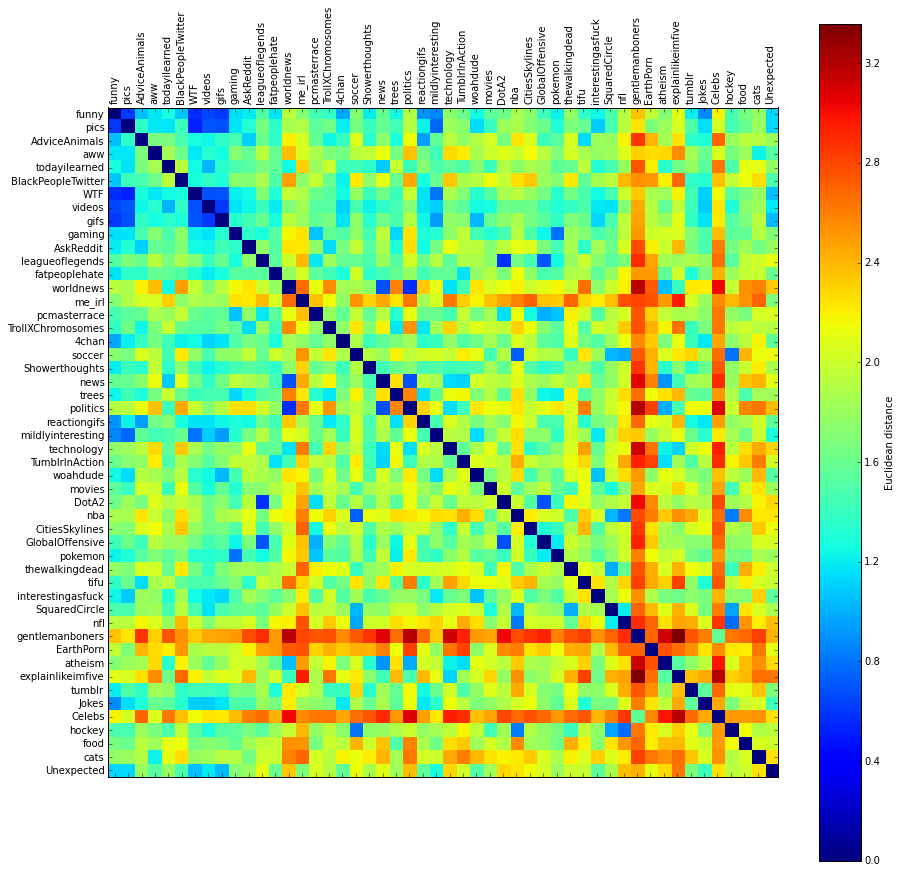

In [17]:
fig, ax = pp.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
tempMat = distMat.copy()
tempMat[tempMat > 4] = 4.
axMat = ax.matshow(tempMat)
ax.set_xticks(range(len(distMat)))
ax.set_xticklabels(subList, rotation=90);
ax.set_yticks(range(len(distMat)))
ax.set_yticklabels(subList);
cbar = fig.colorbar(axMat)
cbar.set_label('Euclidean distance')

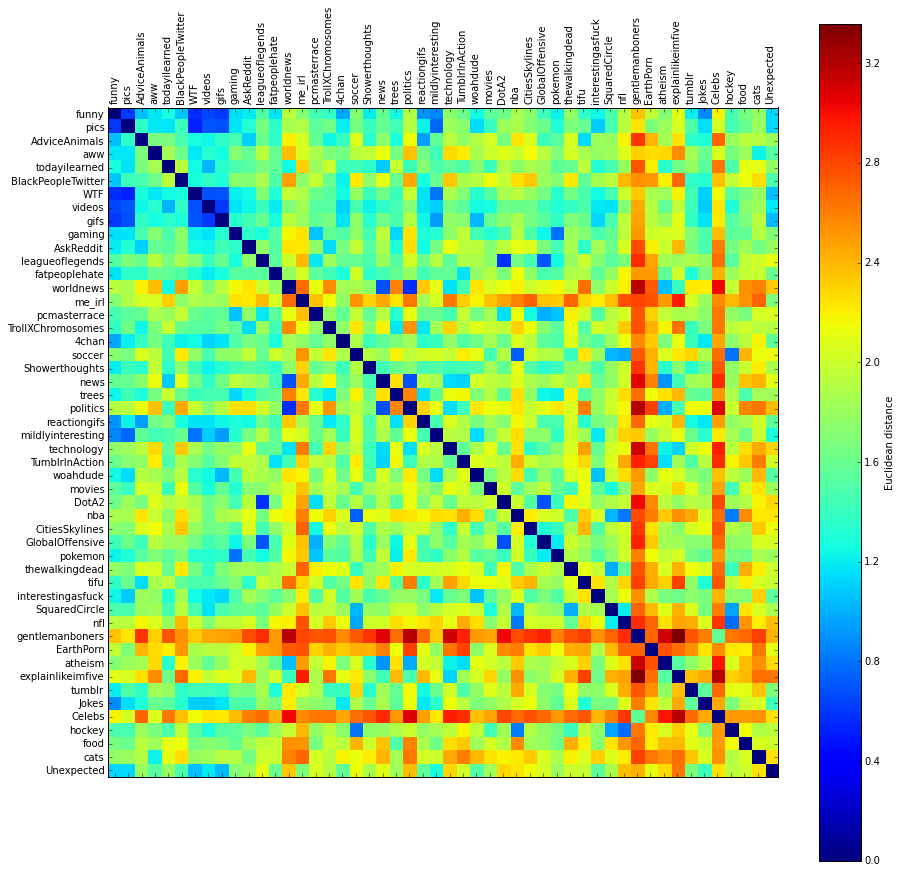

In [18]:
fig, ax = pp.subplots()
fig.set_figheight(15)
fig.set_figwidth(15)
axMat = ax.matshow(distMat)
ax.set_xticks(range(len(distMat)))
ax.set_xticklabels(subList, rotation=90);
ax.set_yticks(range(len(distMat)))
ax.set_yticklabels(subList);
cbar = fig.colorbar(axMat)
cbar.set_label('Euclidean distance')

In [19]:
""" Plot most 10 most similar pairs"""
x = distMat.copy()
np.fill_diagonal(x, np.inf)
for ind in range(30):
    minInd = np.argmin(x)
    inds = np.unravel_index(minInd, distMat.shape)
    print usedSubs[inds[0]] + ', ' + usedSubs[inds[1]] + ': ' + str(x[inds])
    x[inds] = np.inf
    x[inds[1], inds[0]] = np.inf

pics, WTF: 0.529194498586
worldnews, politics: 0.572108787825
funny, WTF: 0.574709109728
leagueoflegends, DotA2: 0.589348374039
funny, gifs: 0.606690602781
videos, gifs: 0.614537677972
funny, pics: 0.614653778703
funny, videos: 0.649791808826
DotA2, GlobalOffensive: 0.68541403954
news, politics: 0.686506614742
worldnews, news: 0.687222251258
WTF, videos: 0.689165525503
pics, gifs: 0.69167598158
pics, videos: 0.695526822692
leagueoflegends, GlobalOffensive: 0.697675078919
WTF, gifs: 0.699228999606
soccer, nba: 0.737252568008
pics, mildlyinteresting: 0.754037975173
nfl, hockey: 0.782857800464
gaming, pokemon: 0.787954943011
soccer, hockey: 0.800760762069
WTF, mildlyinteresting: 0.808809540217
nba, nfl: 0.818915043251
nba, hockey: 0.837989604176
funny, mildlyinteresting: 0.867253441526
funny, Jokes: 0.880611376985
news, atheism: 0.909304948986
funny, reactiongifs: 0.91686337531
gifs, mildlyinteresting: 0.937395438582
AdviceAnimals, reactiongifs: 0.947174098542


In [20]:
""" Plot most 10 most dissimilar pairs"""
x = distMat.copy()
np.fill_diagonal(x, -1*np.inf)
for ind in range(30):
    maxInd = np.argmax(x)
    inds = np.unravel_index(maxInd, distMat.shape)
    print usedSubs[inds[0]] + ', ' + usedSubs[inds[1]] + ': ' + str(x[inds])
    x[inds] = -1*np.inf
    x[inds[1], inds[0]] = -1*np.inf

gentlemanboners, explainlikeimfive: 3.35833106634
explainlikeimfive, Celebs: 3.19348543567
politics, gentlemanboners: 3.19235726317
worldnews, gentlemanboners: 3.1822510436
gentlemanboners, atheism: 3.13398080691
technology, gentlemanboners: 3.12796752833
politics, Celebs: 3.07518945943
news, gentlemanboners: 3.06310800528
worldnews, Celebs: 3.02987852407
DotA2, gentlemanboners: 3.02441237927
atheism, Celebs: 2.98289990617
me_irl, explainlikeimfive: 2.96082252496
technology, Celebs: 2.94896278716
GlobalOffensive, gentlemanboners: 2.93783474644
TumblrInAction, gentlemanboners: 2.92774507157
news, Celebs: 2.90696520199
nfl, gentlemanboners: 2.89785938665
TumblrInAction, Celebs: 2.89613175357
leagueoflegends, gentlemanboners: 2.89108265127
CitiesSkylines, gentlemanboners: 2.87053052537
Showerthoughts, gentlemanboners: 2.86791998319
AdviceAnimals, gentlemanboners: 2.86686310906
nfl, Celebs: 2.86457042876
politics, EarthPorn: 2.83291513989
gentlemanboners, cats: 2.83283842633
tifu, gentlema

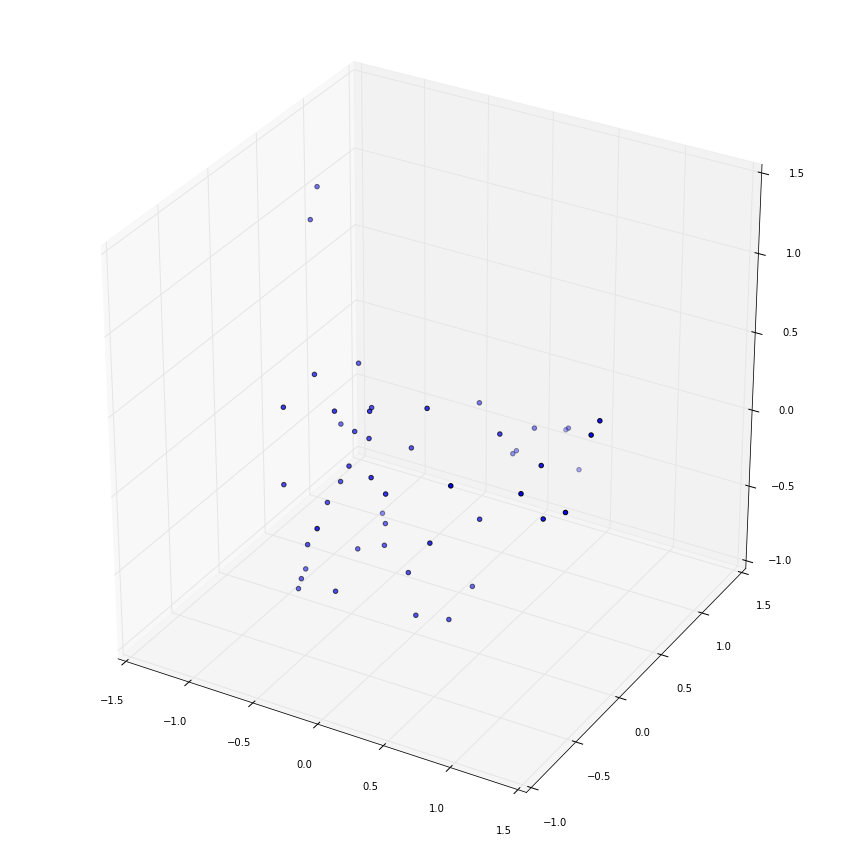

In [21]:
""" perform pca """
pcaObj = decomposition.PCA(n_components=3)
reducedCounts = pcaObj.fit_transform(normCounts.transpose())
fig = pp.figure(figsize=(15,15))
ax = pp.subplot(projection='3d')
ax.scatter(reducedCounts[:,0], reducedCounts[:,1], reducedCounts[:,2])

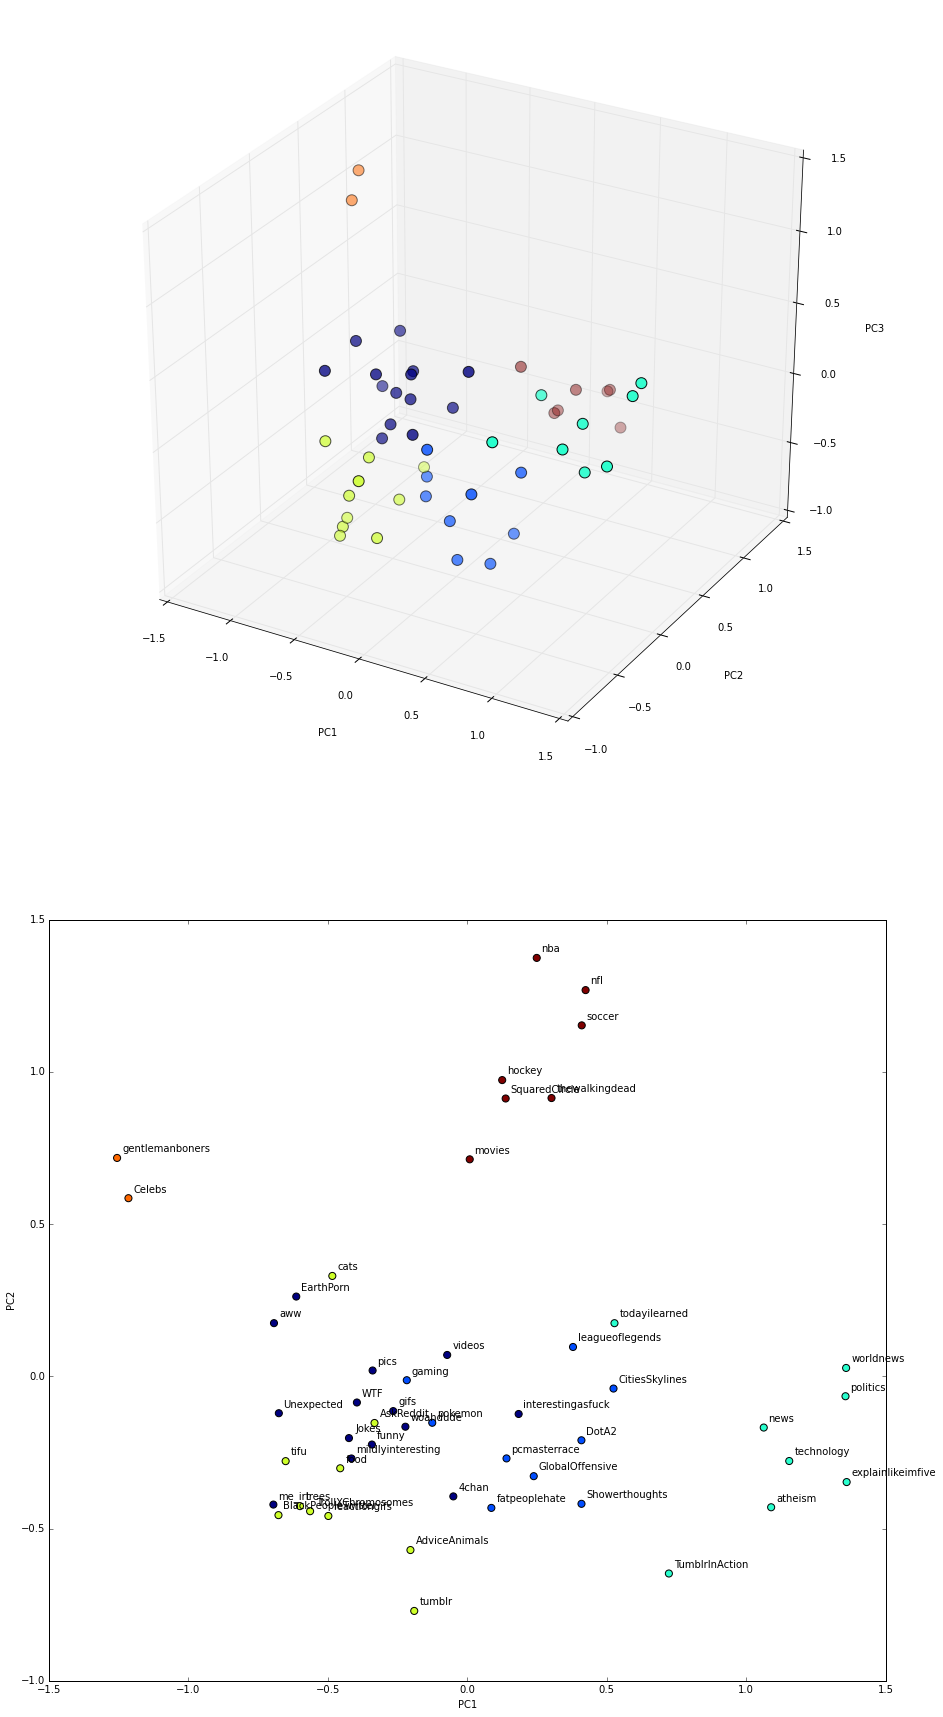

In [22]:
""" cluster points """
apObj = cluster.AffinityPropagation(damping=0.75)
apObj.fit(reducedCounts)

# plot 3d
#%matplotlib qt
%matplotlib inline
fig = pp.figure(figsize=(15,30))
ax = pp.subplot(2,1,1, projection='3d')
ax.scatter(reducedCounts[:,0], reducedCounts[:,1], reducedCounts[:,2], s=120, c=apObj.labels_)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')

#plot 2d 
ax2 = pp.subplot(2,1,2)
ax2.scatter(reducedCounts[:,0], reducedCounts[:,1], s=50, c=apObj.labels_)
ax2.set_xlabel('PC1'); ax2.set_ylabel('PC2')

# label points 
for point in range(len(usedSubs)):
    ax2.text(reducedCounts[point,0]+0.02, reducedCounts[point,1]+0.02, usedSubs[point])

In [ ]:
""" animate """ 

def animate(i, ax):
    newVal = i*5
    if newVal > 360:
        newVal = 0
    ax.azim = newVal

import matplotlib.animation as animation
%matplotlib qt 
fig = pp.figure(figsize=(15,15))
ax = pp.subplot(projection='3d')
ax.scatter(reducedCounts[:,0], reducedCounts[:,1], reducedCounts[:,2], s=120, c=apObj.labels_)
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
ax.elev = 10
ani = animation.FuncAnimation(fig, animate, fargs=[ax], frames=range(int(1e1)), interval=125)
pp.rcParams['animation.ffmpeg_path'] = 'C:\\ffmpeg\\bin\\ffmpeg.exe'
#Writer = animation.writers['ffmpeg']
ani.save('D:\Desktop\test.mp4')

In [78]:
""" plot word distribution """ 
barSubs = ['gentlemanboners', 'Celebs', 'news']

fig, ax = pp.subplots()
width = 1./(len(barSubs)+1)
for sub, ind in zip(barSubs, range(len(barSubs))):
    
    ax.bar([i + ind*width for i in range(len(mostFreqWords))], normCounts[:,usedSubs.index(barSubs[ind])], width)  


In [77]:
width

0